In [1]:
import numpy as np
from scipy import stats
import itertools 

NODES = 1899
f = open("/Users/ans/Documents/kurs_projekat/CollegeMsg.txt","r")
adj_matrix = np.zeros((NODES, NODES))
edges = []
for i, line in enumerate(f):
    elements = line.split()
#     if int(elements[0])-1 >=NODES or int(elements[1])-1>=NODES: continue
    if i<5: print ('Input of the shape - source:{}, target:{}, timestamp:{}'.\
                       format(elements[0], elements[1], elements[2]))
    adj_matrix [int(elements[0])-1, int(elements[1])-1] = 1 
edges = np.where(adj_matrix!=0)
edges = list(zip(edges[0], edges[1]))
f.close()
print ("Edges List:{}".format(edges[:10]))
EDGES = len(edges)
print ("Nodes: {}, Edges: {}".format(NODES, EDGES))

Input of the shape - source:1, target:2, timestamp:1082040961
Input of the shape - source:3, target:4, timestamp:1082155839
Input of the shape - source:5, target:2, timestamp:1082414391
Input of the shape - source:6, target:7, timestamp:1082439619
Input of the shape - source:8, target:7, timestamp:1082439756
Edges List:[(0, 1), (0, 2), (0, 29), (0, 31), (0, 35), (0, 41), (0, 43), (0, 100), (0, 122), (0, 131)]
Nodes: 1899, Edges: 20296


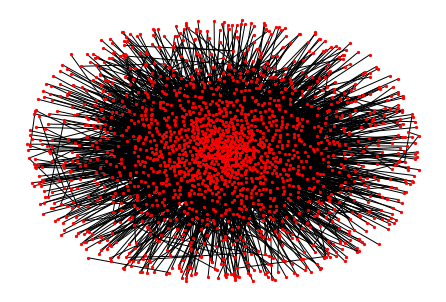

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adj_matrix):
    rows, cols = np.where(adj_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    p = nx.spring_layout(gr,iterations=50, seed=4321, k=0.25)
    nx.draw(gr, node_size=5, edge_size=0.02, pos=p, node_color='red')
    plt.show()

show_graph_with_labels(adj_matrix)

In [3]:
params = {}
def find_distributions(edges, adj_matrix, params):
    params['q_out'] = {k:0 for k in range(NODES)}
    params['q_in'] = {k:0 for k in range(NODES)}
    params['q_apostr_out'] = {k:0 for k in range(NODES)}
    params['q_apostr_in'] = {k:0 for k in range(NODES)}
    params['e_jk_in'] = {(j, k):0 for k in range(NODES) for j in range(NODES)}
    params['e_jk_out'] = {(j, k):0 for k in range(NODES) for j in range(NODES)}
    for edge in edges:
        source = edge[0]
        target = edge[1]
        
        out_source = np.sum(adj_matrix[source])
        in_source = np.sum(adj_matrix[:, source])
        out_target = np.sum(adj_matrix[target])
        in_target = np.sum(adj_matrix[:, target])
        
        params['q_out'][out_source]+=1
        params['q_in'][in_target]+=1
        params['q_apostr_out'][out_target]+=1
        params['q_apostr_in'][in_source]+=1
        params['e_jk_in'][(in_source, in_target)] +=1
        params['e_jk_out'][(out_source, out_target)] +=1
        
    params['q_out'] = {k: v / EDGES for k, v in params['q_out'].items()}
    params['q_in'] = {k: v / EDGES for k, v in params['q_in'].items()}
    params['q_apostr_out'] = {k: v / EDGES for k, v in params['q_apostr_out'].items()}
    params['q_apostr_in'] = {k: v / EDGES for k, v in params['q_apostr_in'].items()}
    params['e_jk_in'] = {k: v / EDGES for k, v in params['e_jk_in'].items()}
    params['e_jk_out'] = {k: v / EDGES for k, v in params['e_jk_out'].items()}
    
    print ("Check that it is a distribution for q_out, sum of prob:{}".format(\
                                                            np.sum(list(params['q_out'].values()))))
    
    q_out = stats.rv_discrete(values=(list(params['q_out'].keys()), list(params['q_out'].values())))
    params['mu_q_out'], params['sigma_q_out'] = q_out.mean(), q_out.std()
    
    q_in = stats.rv_discrete(values=(list(params['q_in'].keys()), list(params['q_in'].values())))
    params['mu_q_in'], params['sigma_q_in'] = q_in.mean(), q_in.std()
    
    q_apostr_out = stats.rv_discrete(values=(list(params['q_apostr_out'].keys()), list(params['q_apostr_out'].values())))
    params['mu_q_apostr_out'], params['sigma_q_apostr_out'] = q_apostr_out.mean(), q_apostr_out.std()
    
    q_apostr_in = stats.rv_discrete(values=(list(params['q_apostr_in'].keys()), list(params['q_apostr_in'].values())))
    params['mu_q_apostr_in'], params['sigma_q_apostr_in'] = q_apostr_in.mean(), q_apostr_in.std()
    
    return params
params = find_distributions(edges, adj_matrix, params) 

Check that it is a distribution for q_out, sum of prob:1.0


In [4]:
def calc_assortativity(params): 
    r_in = 1/(params['sigma_q_in']*params['sigma_q_apostr_in']) 
    r_out = 1/(params['sigma_q_out']*params['sigma_q_apostr_out']) 
    r_d = 1/(params['sigma_q_in']*params['sigma_q_out'])
    sum_in = 0
    sum_out = 0
    for j, k in list(itertools.product(range(NODES), range(NODES))):
        sum_in += j*k*params['e_jk_in'][(j, k)]
        sum_out += j*k*params['e_jk_out'][(j, k)]
        #print (j, k, params['e_jk_in'][(j, k)], j*k*params['e_jk_in'][(j, k)] , params['mu_q_in']*params['mu_q_apostr_in'])
    r_in*=(sum_in - params['mu_q_in']*params['mu_q_apostr_in'])
    r_out*=(sum_out - params['mu_q_out']*params['mu_q_apostr_out'])
    r_d*=(sum_out - params['mu_q_in']*params['mu_q_out'])
    return r_in, r_out, r_d
r_in, r_out, r_d = calc_assortativity(params)
print ("In-assortativity r_in:{}".format(r_in))
print ("Out-assortativity r_out:{}".format(r_out))
print ("Assortativity for directed graphs r_d:{}".format(r_d))

In-assortativity r_in:-0.09770213804946333
Out-assortativity r_out:-0.14542342221287138
Assortativity for directed graphs r_d:-0.0876427380312248
